In [39]:
!apt-get update
!apt-get install openjdk-8-jdk -y
!wget https://downloads.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install findspark


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 261 kB in 2s (137 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pa

In [40]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("ColabSpark").getOrCreate()
spark


In [41]:
df = spark.createDataFrame([(1, "Apple"), (2, "Banana"), (3, "Cherry")], ["ID", "Fruit"])
df.show()


+---+------+
| ID| Fruit|
+---+------+
|  1| Apple|
|  2|Banana|
|  3|Cherry|
+---+------+



In [42]:
# Install Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark pyspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

# Initialize Spark
import findspark
findspark.init()
from pyspark.sql import SparkSession

# Create a Spark Session
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

# Check if Spark is running
spark


tar: spark-3.3.2-bin-hadoop3.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [43]:
# Download the Titanic dataset (CSV format)
!wget -q https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv -O titanic.csv

# Load dataset into a Spark DataFrame
df = spark.read.csv("titanic.csv", header=True, inferSchema=True)

# Show first 5 rows
df.show(5)


+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

In [44]:
#register the dataFrame as a SQL Table
df.createOrReplaceTempView("titanic")

spark.sql("SELECT Sex, COUNT(*) AS count FROM titanic GROUP BY Sex").show()

+------+-----+
|   Sex|count|
+------+-----+
|female|  314|
|  male|  577|
+------+-----+



In [45]:
#Survival Rate per passenger class

spark.sql("SELECT Pclass, AVG(Survived) AS survival_rate FROM titanic GROUP BY Pclass ORDER BY Pclass").show()

+------+-------------------+
|Pclass|      survival_rate|
+------+-------------------+
|     1| 0.6296296296296297|
|     2|0.47282608695652173|
|     3|0.24236252545824846|
+------+-------------------+



In [46]:
#Avg age of survivors vs non-survivors
spark.sql("SELECT Survived, AVG(age) AS avg_age FROM titanic GROUP BY Survived").show()

+--------+------------------+
|Survived|           avg_age|
+--------+------------------+
|       1|28.343689655172415|
|       0| 30.62617924528302|
+--------+------------------+



In [47]:
from pyspark.sql.functions import sum,col

#count the missing values in each column
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [48]:
df = df.drop("Cabin")

In [49]:
from pyspark.sql.functions import avg,expr

#Calculate median age
median_age = df.approxQuantile("Age",[0.5], 0.01)[0]

#Fill missing age values
df = df.fillna({"Age": median_age})

In [50]:
from pyspark.sql.functions import mode

# Find the most common port
common_port = df.groupBy("Embarked").count().orderBy("count", ascending=False).first()["Embarked"]

# Fill missing values
df = df.fillna({"Embarked": common_port})


In [51]:
from pyspark.ml.feature import StringIndexer

# Convert categorical columns
indexer = StringIndexer(inputCol="Sex", outputCol="SexIndex")
df = indexer.fit(df).transform(df)

indexer = StringIndexer(inputCol="Embarked", outputCol="EmbarkedIndex")
df = indexer.fit(df).transform(df)

df.select("Sex", "SexIndex", "Embarked", "EmbarkedIndex").show(5)


+------+--------+--------+-------------+
|   Sex|SexIndex|Embarked|EmbarkedIndex|
+------+--------+--------+-------------+
|  male|     0.0|       S|          0.0|
|female|     1.0|       C|          1.0|
|female|     1.0|       S|          0.0|
|female|     1.0|       S|          0.0|
|  male|     0.0|       S|          0.0|
+------+--------+--------+-------------+
only showing top 5 rows



In [52]:
df = df.dropDuplicates()  # Remove duplicate rows
df = df.drop("Name", "Ticket")  # Drop irrelevant columns


In [53]:
df.printSchema()  # Check column types
df.show(5)        # Preview cleaned data


root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = false)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- SexIndex: double (nullable = false)
 |-- EmbarkedIndex: double (nullable = false)

+-----------+--------+------+------+----+-----+-----+------+--------+--------+-------------+
|PassengerId|Survived|Pclass|   Sex| Age|SibSp|Parch|  Fare|Embarked|SexIndex|EmbarkedIndex|
+-----------+--------+------+------+----+-----+-----+------+--------+--------+-------------+
|        357|       1|     1|female|22.0|    0|    1|  55.0|       S|     1.0|          0.0|
|        536|       1|     2|female| 7.0|    0|    2| 26.25|       S|     1.0|          0.0|
|          6|       0|     3|  male|28.0|    0|    0|8.4583|       Q|     0.0|          2.0|
|

In [54]:
#Check Schema(data type columns)

df.printSchema()


root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = false)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- SexIndex: double (nullable = false)
 |-- EmbarkedIndex: double (nullable = false)



In [55]:
df.describe().show()


+-------+-----------------+-------------------+------------------+------+------------------+------------------+-------------------+-----------------+--------+-------------------+------------------+
|summary|      PassengerId|           Survived|            Pclass|   Sex|               Age|             SibSp|              Parch|             Fare|Embarked|           SexIndex|     EmbarkedIndex|
+-------+-----------------+-------------------+------------------+------+------------------+------------------+-------------------+-----------------+--------+-------------------+------------------+
|  count|              891|                891|               891|   891|               891|               891|                891|              891|     891|                891|               891|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|  NULL| 29.36158249158249|0.5230078563411896|0.38159371492704824|32.20420796857455|    NULL|0.35241301907968575|0.3613916947250281|
| stddev|2

In [56]:
# Convert to Pandas
df_pd = df.toPandas()

# Check data
df_pd.head()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,SexIndex,EmbarkedIndex
0,357,1,1,female,22.0,0,1,55.0000,S,1.0,0.0
1,536,1,2,female,7.0,0,2,26.2500,S,1.0,0.0
2,6,0,3,male,28.0,0,0,8.4583,Q,0.0,2.0
3,150,0,2,male,42.0,0,0,13.0000,S,0.0,0.0
4,375,0,3,female,3.0,3,1,21.0750,S,1.0,0.0


Survival Count


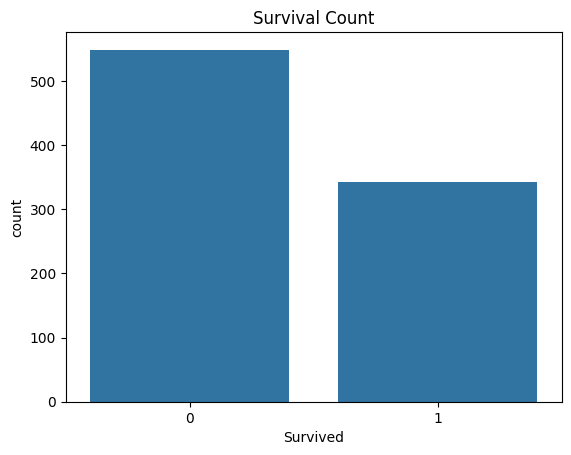

In [57]:
import seaborn as sns  # For visualization
import matplotlib.pyplot as plt  # For displaying the plot

sns.countplot(x=df_pd["Survived"])
plt.title("Survival Count")
plt.show()

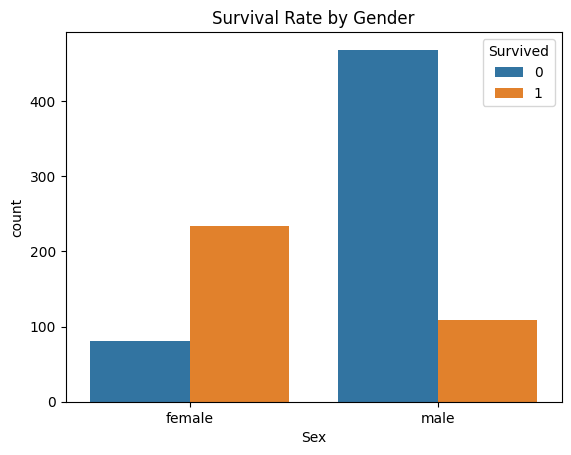

In [58]:
#Survival Rate by Gender

sns.countplot(x="Sex", hue="Survived", data=df_pd)
plt.title("Survival Rate by Gender")
plt.show()

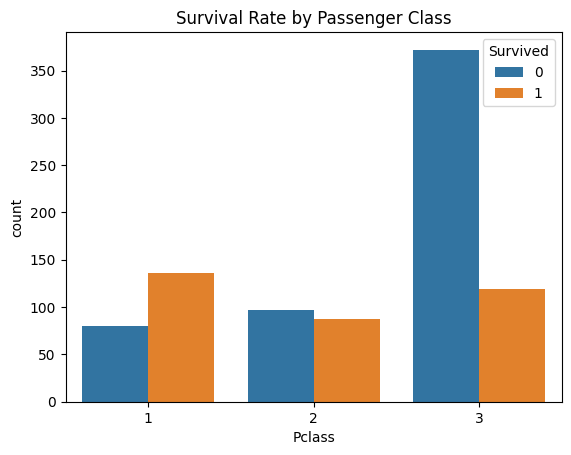

In [59]:
sns.countplot(x="Pclass", hue="Survived", data=df_pd)
plt.title("Survival Rate by Passenger Class")
plt.show()


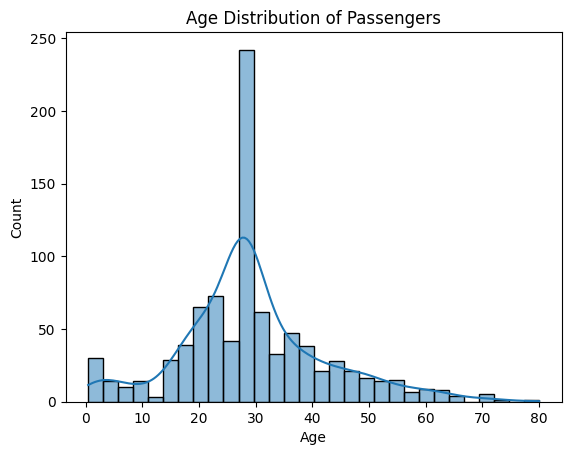

In [60]:
sns.histplot(df_pd["Age"], bins=30, kde=True)
plt.title("Age Distribution of Passengers")
plt.show()


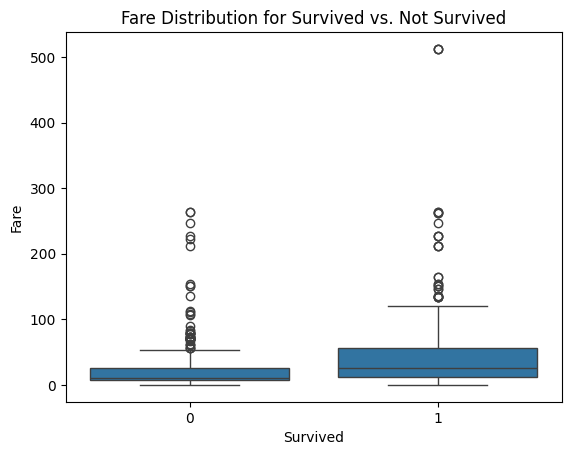

In [61]:
sns.boxplot(x="Survived", y="Fare", data=df_pd)
plt.title("Fare Distribution for Survived vs. Not Survived")
plt.show()


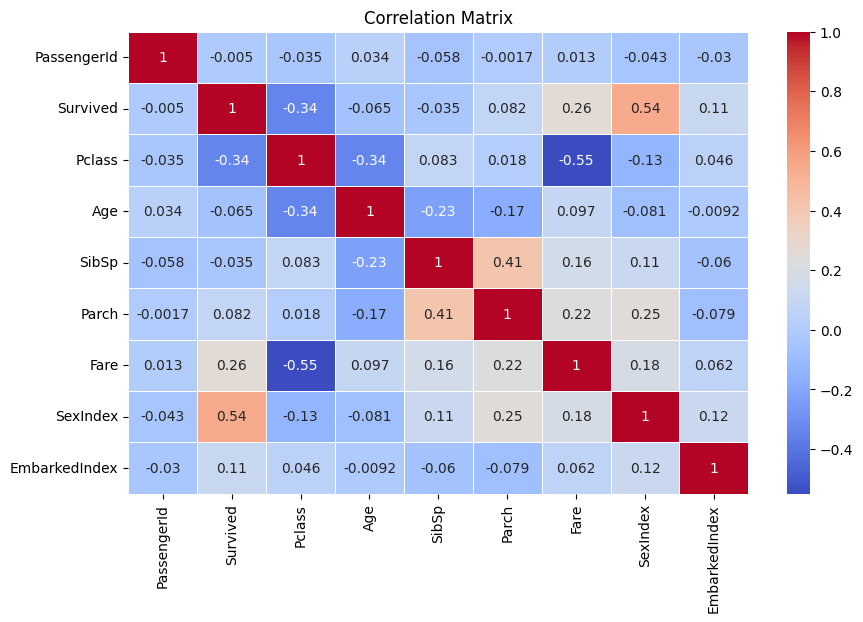

In [62]:
# Select only numerical columns
df_corr = df_pd.select_dtypes(include=['number'])

# Now plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_corr.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


In [63]:
!pip install pyspark


In [64]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("TitanicRDD").getOrCreate()

# Load dataset as RDD (assuming titanic.csv is in your Colab files)
titanic_rdd = spark.sparkContext.textFile("/content/titanic.csv")

# Show first 5 rows
titanic_rdd.take(5)


['PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked',
 '1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S',
 '2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C',
 '3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S',
 '4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S']

In [66]:
from ctypes import Structure
header = titanic_rdd.first() #extract header
data_rdd = titanic_rdd.filter(lambda row: row != header) #remove header

#split each row by comma
structured_rdd = data_rdd.map(lambda row: row.split(","))

#show first 5 structred rows
structured_rdd.take(5)

[['1',
  '0',
  '3',
  '"Braund',
  ' Mr. Owen Harris"',
  'male',
  '22',
  '1',
  '0',
  'A/5 21171',
  '7.25',
  '',
  'S'],
 ['2',
  '1',
  '1',
  '"Cumings',
  ' Mrs. John Bradley (Florence Briggs Thayer)"',
  'female',
  '38',
  '1',
  '0',
  'PC 17599',
  '71.2833',
  'C85',
  'C'],
 ['3',
  '1',
  '3',
  '"Heikkinen',
  ' Miss. Laina"',
  'female',
  '26',
  '0',
  '0',
  'STON/O2. 3101282',
  '7.925',
  '',
  'S'],
 ['4',
  '1',
  '1',
  '"Futrelle',
  ' Mrs. Jacques Heath (Lily May Peel)"',
  'female',
  '35',
  '1',
  '0',
  '113803',
  '53.1',
  'C123',
  'S'],
 ['5',
  '0',
  '3',
  '"Allen',
  ' Mr. William Henry"',
  'male',
  '35',
  '0',
  '0',
  '373450',
  '8.05',
  '',
  'S']]

In [69]:
def clean_data(row):
    try:
        return (int(row[0]), row[1], row[2], int(row[5]), row[6], row[7], float(row[9]), int(row[1]))
    except:
        return None  # Ignore rows with missing/invalid data

cleaned_rdd = structured_rdd.map(clean_data).filter(lambda row: row is not None)

cleaned_rdd.take(5)


[]